In [ ]:
!pip install transformers

In [ ]:
# generics 
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import random


!pip install pytypo
import pytypo

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import torch.nn.functional as F

from transformers import BertTokenizer, AutoModel, BertConfig, TFBertModel, AdamW, get_linear_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup, BertConfig, get_constant_schedule_with_warmup

# import warnings
# warnings.filterwarnings('FutureWarning')

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(29092020)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

In [ ]:
# df = pd.read_excel('./drive/My Drive/satdat/dataset.xlsx')
df_train = pd.read_csv('./drive/My Drive/satdat/train.csv')
df_val = pd.read_csv('./drive/My Drive/satdat/val.csv')
test = pd.read_csv('./drive/My Drive/satdat/datatest_labelled.csv')

In [ ]:
# df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
# df_train.to_csv("./drive/My Drive/satdat/b_train.csv")
# df_val.to_csv('./drive/My Drive/satdat/b_val.csv')

In [ ]:
def clean(text) : 

  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[#]+|[^A-Za-z0-9]+"
  text_cleaning_hash = "#[A-Za-z0-9]+" 
  text_cleaning_num = "(^|\W)\d+"

  text = re.sub(text_cleaning_hash, " ", text).strip()
  text = re.sub(text_cleaning_num, " ", text).strip()
  text = re.sub(text_cleaning_re, " ", text).strip()
  
  text = text.strip()

  out = []
  for word in text.split() :
    # try : 
    #   out.append(word.replace(word, slang[word]))
    # except Exception as e : 
    out.append(word)
      
  return pytypo.correct_sentence(" ".join(out).strip())

slang = pd.read_csv('./drive/My Drive/satdat/slang.csv')
slang = slang[['slang', 'formal']]
slang = slang.set_index('slang')['formal'].to_dict()


df_train.narasi = df_train.narasi.apply(lambda x: clean(x)) 
df_train.judul = df_train.judul.apply(lambda x: clean(x))

df_val.narasi = df_val.narasi.apply(lambda x: clean(x)) 
df_val.judul = df_val.judul.apply(lambda x: clean(x))

test.narasi = test.narasi.apply(lambda x: clean(x))
test.judul = test.judul.apply(lambda x: clean(x))

In [ ]:
class HoaxDataset(Dataset) : 
  def __init__(self, feature1, feature2, label, tokenizer, max_len, no_label=False) : 
    self.feature1 = feature1
    self.feature2 = feature2
    self.label = label 
    self.tokenizer = tokenizer 
    self.max_len = max_len 
    self.no_label = no_label

  def __len__(self) : 
    return len(self.feature1)
  
  def __getitem__(self, item) :
    feature1 = str(self.feature1[item])
    feature2 = str(self.feature2[item])
    if not self.no_label: 
      label = self.label[item]

    encoding1 = tokenizer.encode_plus(
        # ntar diganti <----------------------------------------------------
        feature1, 
        max_length=64,
        add_special_tokens=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        truncation=True, 
        pad_to_max_length=True,
        return_tensors='pt'
    )

    encoding2 = tokenizer.encode_plus(
        feature2, 
        max_length=32,
        add_special_tokens=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        truncation=True, 
        pad_to_max_length=True,
        return_tensors='pt'
    )
    
    if not self.no_label :
      return {
          'narasi_text' : feature1,
          'narasi_input_ids' : encoding1['input_ids'].flatten(), 
          'narasi_attention_mask' : encoding1['attention_mask'].flatten(), 

          'judul_narasi_text' : feature2,
          'judul_input_ids' : encoding2['input_ids'].flatten(), 
          'judul_attention_mask' : encoding2['attention_mask'].flatten(), 

          'label' : torch.tensor(label, dtype=torch.long)

      }
    else : 
      return {
          'narasi_text' : feature1,
          'narasi_input_ids' : encoding1['input_ids'].flatten(), 
          'narasi_attention_mask' : encoding1['attention_mask'].flatten(), 

          'judul_narasi_text' : feature2,
          'judul_input_ids' : encoding2['input_ids'].flatten(), 
          'judul_attention_mask' : encoding2['attention_mask'].flatten(), 

      }


def to_data_loader(df, columns, label, tokenizer, max_len, batch_size) : 
  ds = HoaxDataset(
      df[columns[0]], 
      df[columns[1]], 
      df[label],
      tokenizer=tokenizer, 
      max_len=max_len, 
  )

  return DataLoader(
      ds, 
      batch_size=batch_size, 
  )

def test_to_data_loader(df, columns, tokenizer, max_len, batch_size) : 
  ds = HoaxDataset(
      df[columns[0]], 
      df[columns[1]], 
      None,
      tokenizer=tokenizer, 
      max_len=max_len, 
      no_label=True
  )

  return DataLoader(
      ds, 
      batch_size=batch_size, 
  )

In [ ]:
train_data_loader = to_data_loader(df_train, ['narasi', 'judul'], 'label', tokenizer, 64, 32)
val_data_loader = to_data_loader(df_val, ['narasi', 'judul'], 'label', tokenizer, 64, 32)
test_data_loader = test_to_data_loader(test, ['narasi', 'judul'], tokenizer, 64, 32)

In [ ]:
data = next(iter(test_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['narasi_text', 'narasi_input_ids', 'narasi_attention_mask', 'judul_narasi_text', 'judul_input_ids', 'judul_attention_mask'])

In [ ]:
class HoaxClassifier(nn.Module) : 
  def __init__(self, n_classes) : 
    super(HoaxClassifier, self).__init__() 
    config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')

    self.bert1 = AutoModel.from_pretrained("indobenchmark/indobert-base-p1", config=config)
    self.bert2 = AutoModel.from_pretrained("indobenchmark/indobert-base-p1", config=config)

    self.drop = nn.Dropout(p=0.5)

    self.relu = nn.ReLU()

    self.tanh = nn.Tanh()

    self.dual_bert = nn.Linear(self.bert1.config.hidden_size * 2, 32)

    self.out = nn.Linear(32, 2) 



  def forward(self, narasi_input_ids, narasi_attention_mask, judul_input_ids, judul_attention_mask) :
    _, pooled_output1 = self.bert1(
        input_ids = narasi_input_ids, 
        attention_mask = narasi_attention_mask
    )

    _, pooled_output2 = self.bert2(
        input_ids = judul_input_ids, 
        attention_mask = judul_attention_mask
    )

    x = torch.cat((pooled_output1, pooled_output2), dim=1)

    x = self.drop(x)
    x = self.dual_bert(x)
    x = self.tanh(x) 

    x = self.drop(x)
    x = self.out(x)

    return x

In [ ]:
model = HoaxClassifier(2)
model.to(device)

HoaxClassifier(
  (bert1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
# load freezed only if already exist
# model.load_state_dict(torch.load('/content/drive/My Drive/satdat/freezed_state.bin'))

In [ ]:
# toggle to train non embeddings
model.bert1.embeddings.requires_grad_=True
model.bert2.embeddings.requires_grad_=True

In [ ]:
EPOCHS = 8
opt = AdamW(model.parameters(), lr=3e-5, correct_bias=False, weight_decay=1e-4)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_constant_schedule_with_warmup(
    opt, 
    num_warmup_steps=0, 
    # num_training_steps=total_steps, 

)

loss_function = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch (model, data_loader, loss_fn, optimizer, device, scheduler, n_examples) : 

  model = model.train() 

  correct_predictions = 0
  losses = []

  for d in data_loader : 
    input_ids1 = d['narasi_input_ids'].to(device)
    input_ids2 = d['judul_input_ids'].to(device)

    input_mask1 = d['narasi_attention_mask'].to(device)
    input_mask2 = d['judul_attention_mask'].to(device)

    label = d['label'].to(device)

    outputs = model(
        input_ids1, 
        input_mask1, 
        input_ids2, 
        input_mask2
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, label)

    correct_predictions += torch.sum(preds == label)
    losses.append(loss.item())


    loss.backward() 
    nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step() 
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples) : 
  model = model.eval() 

  losses = []
  correct_predictions=0

  with torch.no_grad() : 
    for d in data_loader :
      input_ids1 = d['narasi_input_ids'].to(device)
      input_ids2 = d['judul_input_ids'].to(device)

      input_mask1 = d['narasi_attention_mask'].to(device)
      input_mask2 = d['judul_attention_mask'].to(device)

      label = d['label'].to(device)

      outputs = model(
        input_ids1, 
        input_mask1, 
        input_ids2, 
        input_mask2
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, label)

      correct_predictions += torch.sum(preds == label)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_function, 
    opt, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_function, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)



  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model.bin')
    best_accuracy = val_acc


Epoch 1/8
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Train loss 0.49271536699864044 accuracy 0.8163908589440505
Val   loss 0.41279488056898117 accuracy 0.8608490566037735

Epoch 2/8
----------
Train loss 0.4357091244779715 accuracy 0.8381928027318098
Val   loss 0.3932666629552841 accuracy 0.8726415094339622

Epoch 3/8
----------
Train loss 0.45868178939118104 accuracy 0.8429209351195167
Val   loss 0.40619670173951555 accuracy 0.8655660377358491

Epoch 4/8
----------
Train loss 0.44493169606733723 accuracy 0.8497504596795378
Val   loss 0.3992500017796244 accuracy 0.8702830188679245

Epoch 5/8
----------
Train loss 0.42953632696836935 accuracy 0.8481744155503022
Val   loss 0.5043437821524483 accuracy 0.7665094339622641

Epoch 6/8
----------
Train loss 0.43514179494701516 accuracy 0.8387181507748884
Val   loss 0.3823168969580105 accuracy 0.875

Epoch 7/8
----------
Train loss 0.4622225541026652 accuracy 0.837404780667192
Val   loss 0.43377709708043505 accuracy 0.8490566037735848

Epoch 8/8
----------
Train loss 0.4732806594932781 accuracy 0

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  prediction_probs = []

  with torch.no_grad():
    for d in data_loader:

      input_ids1 = d['narasi_input_ids'].to(device)
      input_ids2 = d['judul_input_ids'].to(device)

      input_mask1 = d['narasi_attention_mask'].to(device)
      input_mask2 = d['judul_attention_mask'].to(device)


      outputs = model(
        input_ids1, 
        input_mask1, 
        input_ids2, 
        input_mask2
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      predictions.extend(preds)
      prediction_probs.extend(probs)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  return predictions, prediction_probs

In [ ]:
# load best model 
model.load_state_dict(torch.load('./best_model.bin'))

<All keys matched successfully>

In [ ]:
y_pred, y_pred_probs = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
y_pred

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
print(classification_report(list(test['label']), y_pred))


              precision    recall  f1-score   support

           0       0.72      0.57      0.64        60
           1       0.94      0.97      0.95       410

    accuracy                           0.92       470
   macro avg       0.83      0.77      0.79       470
weighted avg       0.91      0.92      0.91       470



In [ ]:

print(f1_score(list(test['label']), y_pred, average='micro'))

0.9170212765957447


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

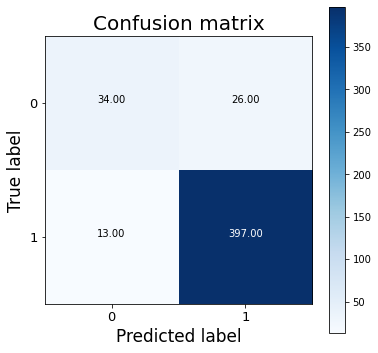

In [ ]:
cnf_matrix = confusion_matrix(test.label.to_list(), y_pred)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'], title="Confusion matrix")
plt.show()